<a href="https://colab.research.google.com/github/sakuronohana/cas_datenanalyse/blob/master/ensemble_cnn_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

gh_train = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/PVA4/data/train.csv'
gh_test = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/PVA4/data/test.csv'

train_data = pd.read_csv(gh_train,header=None,index_col=0)
test_data = pd.read_csv(gh_test,header=None,index_col=0)


#train_data = np.array(train_data.iloc[50])[1:].astype('uint8').reshape(28,28)
#plt.imshow(train_data)

In [38]:
print(train_data.shape)
print(test_data.shape)


(9360, 785)
(9364, 784)


In [0]:
train_target = train_data[1]

del train_data[1]


In [40]:
train_target.count()

9360

In [0]:
train_data = train_data.values
test_data = test_data.values

In [42]:
train_target.nunique()

10

In [0]:
X_train = train_data.reshape(-1, 28, 28 , 1).astype('float32')

In [0]:
X_test = test_data.reshape(-1, 28, 28 , 1).astype('float32')

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [0]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
train_target = enc.fit_transform(train_target.values)

In [0]:
Y_train = to_categorical(train_target, num_classes = 10)

In [0]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=20182019)

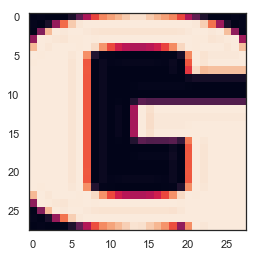

In [51]:
g = plt.imshow(X_train[25][:,:,0])

In [52]:
np.unique(train_target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
from keras.layers import BatchNormalization

In [54]:
from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 15
model = [0] *nets


for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.35))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer='adagrad', loss="categorical_crossentropy", metrics=["accuracy"])
    
print('Done')

Done


In [0]:
# LR Reduction Callback
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:

history = [0] * nets
epochs = 30

datagen = ImageDataGenerator(
    rotation_range=13,
    zoom_range=0.11,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)

for j in range(nets):
    print(f'Net : {j+1}')   
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[learning_rate_reduction], verbose=1)
    
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Net : 1
Epoch 1/30
 14/118 [==>...........................] - ETA: 1:53 - loss: 2.2413 - acc: 0.3426

In [0]:
# make submision
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)


In [0]:
    
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="target")
submission = pd.concat([pd.Series(range(0,9364),name = "Id"),results],axis = 1)


In [0]:
submission.head()

,Id,target
0,0,0
1,1,7
2,2,0
3,3,0
4,4,7


In [0]:
submission['target'] = enc.inverse_transform(submission['target'])

In [0]:
submission.head()

,Id,target
0,0,A
1,1,H
2,2,A
3,3,A
4,4,H


In [0]:
submission.shape

(9364, 2)

In [0]:
submission.target.value_counts()

D    977
J    971
G    954
H    949
E    941
B    933
F    932
C    914
A    912
I    881
Name: target, dtype: int64

In [0]:
submission.to_csv('sub_ensemble_10_cnn.csv', index=False)